In [372]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance


In [373]:
img = cv2.imread('trybik.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 110, 255, cv2.THRESH_BINARY)
binary_inv = cv2.bitwise_not(binary)
gray_filtered = cv2.medianBlur(gray, 5)

_, binary = cv2.threshold(gray_filtered, 130, 255, cv2.THRESH_BINARY)

binary_inv = cv2.bitwise_not(binary)

kernel = np.ones((4, 4), np.uint8)
eroded = cv2.erode(binary_inv, kernel, iterations=1)

dilated = cv2.dilate(eroded, kernel, iterations=1)
binary_inv=dilated


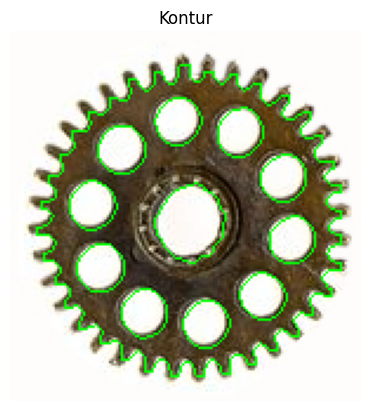

In [374]:


contours, hierarchy = cv2.findContours(binary_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(img, contours,-1, (0, 255, 0), 0)


img_draw = img.copy()



img_draw_rgb = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)

plt.imshow(img_draw_rgb)
plt.title("Kontur")
plt.axis('off')
plt.show()


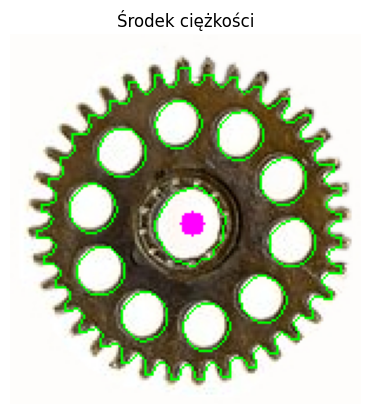

In [375]:
moments = cv2.moments(binary_inv)
cx = int(moments['m10'] / moments['m00'])
cy = int(moments['m01'] / moments['m00'])
img_with_center = img.copy()
cv2.circle(img_with_center, (cx, cy), radius=5, color=(255, 0, 255), thickness=-1)

img_rgb = cv2.cvtColor(img_with_center, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("Środek ciężkości")
plt.axis('off')
plt.show()

In [376]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
orientation = np.arctan2(sobely, sobelx)
orientation_deg = (np.rad2deg(orientation) % 360).astype(int)

In [377]:
Rtable = [[] for _ in range(360)]
for contour in contours:
    for point in contour:
        x, y = point[0]
        dx = x - cx
        dy = y - cy
        r = np.hypot(dx, dy)
        fi = np.rad2deg(np.arctan2(dy, dx))
        angle_bin = orientation_deg[y, x] % 360
        Rtable[angle_bin].append((r, fi))

In [378]:
img2 = cv2.imread('trybiki2.jpg')
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

sobelx = cv2.Sobel(img2_gray, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(img2_gray, cv2.CV_64F, 0, 1, ksize=5)
magnitude = np.sqrt(sobelx**2 + sobely**2)
orientation = np.arctan2(sobely, sobelx)
orientation_deg = (np.rad2deg(orientation) % 360).astype(int)
magnitude_norm = magnitude / magnitude.max()

In [379]:
hough = np.zeros_like(img2_gray, dtype=np.float32)
h, w = hough.shape

for y in range(h):
    for x in range(w):
        if magnitude_norm[y, x] > 0.15:
            angle = orientation_deg[y, x]
            for r, fi in Rtable[angle]:
                x_c = int(x - r * np.cos(np.deg2rad(fi)))
                y_c = int(y - r * np.sin(np.deg2rad(fi)))
                if 0 <= x_c < w and 0 <= y_c < h:
                    hough[y_c, x_c] += 1

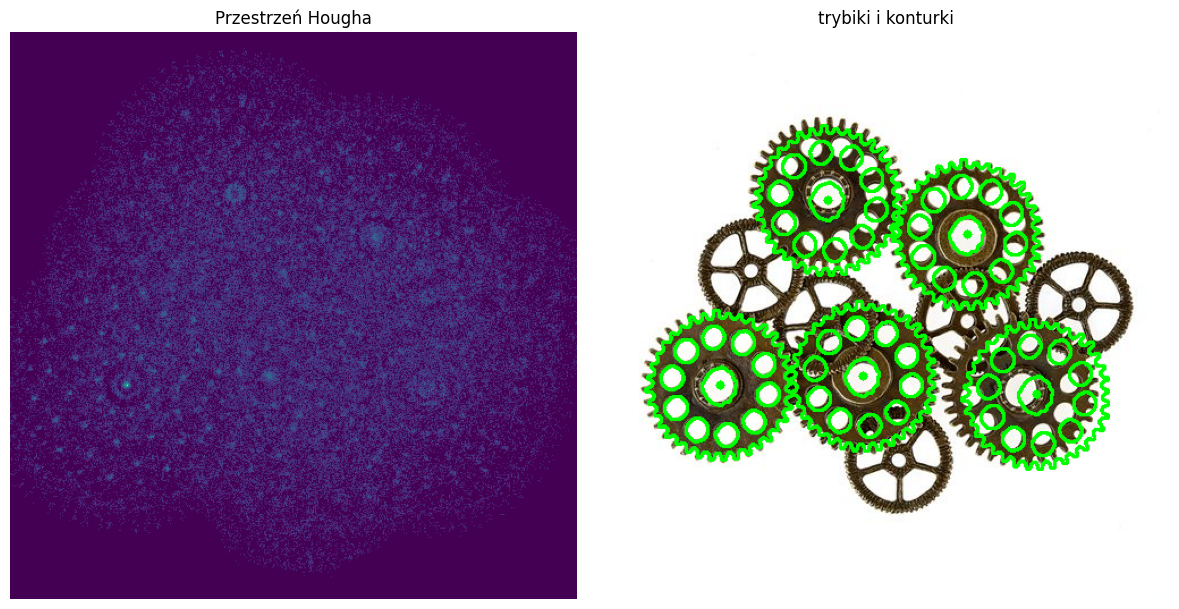

In [380]:
contours, _ = cv2.findContours(binary_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
model_contours = contours  

moments = cv2.moments(binary_inv, binaryImage=True)
cx = int(moments['m10'] / moments['m00'])
cy = int(moments['m01'] / moments['m00'])

def translate_contour(contour, dx, dy):
    translation = np.array([[[dx, dy]]], dtype=np.int32)
    return contour + translation

coordinates = peak_local_max(hough, min_distance=80, threshold_abs=5, num_peaks=5)

result_img = img2.copy()

for y, x in coordinates:
    cv2.circle(result_img, (x, y), radius=4, color=(0, 255, 0), thickness=-1)

    dx = x - cx
    dy = y - cy

    for cnt in model_contours: 
        shifted = translate_contour(cnt, dx, dy)
        cv2.drawContours(result_img, [shifted], 0, (0, 255, 0), 2)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.log1p(hough)) 
axs[0].set_title("Przestrzeń Hougha")
axs[0].axis('off')

axs[1].imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
axs[1].set_title("trybiki i konturki")
axs[1].axis('off')

plt.tight_layout()
plt.show()
